In [1]:
import pandas as pd
import numpy as np
import rioxarray as rxr
import xarray as xr
from pathlib import Path 

import time
import netCDF4

In [2]:
rn_dic = {
    'Cloud_Optical_Thickness_Liquid_Mean':'COT',
    'Cloud_Effective_Radius_Liquid_Mean': 'r_eff',
    'Cloud_Water_Path_Liquid_Mean': 'CWP',
}

In [3]:
produce_files = [
    'Cloud_Optical_Thickness_Liquid_Mean', 
    'Cloud_Effective_Radius_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean',
    'Cloud_Water_Path_Liquid_Mean_Uncertainty',
    'Cloud_Water_Path_Liquid_Standard_Deviation',
    'Cloud_Water_Path_Liquid_Maximum',
    'Cloud_Water_Path_Liquid_Minimum',
]
producw_files_extra=[
    'Cloud_Top_Temperature_Day_Maximum',
    'Cloud_Top_Temperature_Day_Mean',
    'Cloud_Top_Temperature_Day_Minimum',
    'Cloud_Top_Pressure_Day_Mean',
    'Cloud_Top_Pressure_Day_Maximum',
    'Cloud_Top_Pressure_Day_Minimum',
    'Cloud_Top_Height_Day_Mean',
    'Cloud_Top_Height_Day_Maximum',
    'Cloud_Top_Height_Day_Minimum',
    'Cloud_Fraction_Day_Mean',
    'Cloud_Fraction_Day_Maximum',
    'Cloud_Fraction_Day_Minimum',
    'Cloud_Optical_Thickness_Liquid_Maximum',
    #'Cloud_Optical_Thickness_Liquid_Mean',
    'Cloud_Optical_Thickness_Liquid_Mean_Uncertainty',
    'Cloud_Optical_Thickness_Liquid_Minimum',
    'Cloud_Optical_Thickness_Liquid_Standard_Deviation',
    'Cloud_Optical_Thickness_Combined_Mean',
    'Cloud_Optical_Thickness_Combined_Maximum',
    'Cloud_Optical_Thickness_Combined_Minimum',
    'Cloud_Optical_Thickness_Combined_Standard_Deviation',
    'Cloud_Effective_Radius_Liquid_Mean_Uncertainty',
    #'Cloud_Effective_Radius_Liquid_Mean',
]

In [4]:
from bs_fdbck.constants import path_measurement_data

## Settings: 

In [5]:
path_measurement_data

PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data')

In [6]:
# path_raw_data = path_measurement_data /'satellite' / 'MODIS_raw'

# path_out_netcdf = path_measurement_data /'satellite' / 'MODIS_netcdf'

path_out_postproc = path_measurement_data /'satellite' / 'MODIS_postproc'
path_out_postproc_lev2 = path_measurement_data /'satellite' / 'MODIS_postproc_lev2'

station = 'ATTO'
outfilename = path_out_postproc_lev2 / f'MODIS_date_{station}.nc'


fl = list(path_out_postproc.glob('*.nc'))
fl.sort()

In [7]:
tau_lims = [5,50]
r_eff_lim = 5
cloud_top_temp_above = -15 
cld_water_path_above = 50
#include_months = [7,8]

from_year = '2012'
to_year = '2018'
daytime_from = 9
daytime_to = daytime_from + 7

## Set station specifics;

In [8]:
high_perc_OA = 3.02
low_perc_OA = 1.59

In [9]:
(293 + 180) % 360 - 180

-67

In [10]:
[a for a in [1,2]]

[1, 2]

In [11]:
def lon_sh(l):
    return ((l+180)%360-180) 

In [12]:
#lat_lims = [60, 66]
#lon_lims = [22,30]
lon_lims = [293.,308.]
lon_lims =[lon_sh(l) for l in lon_lims]
lat_lims = [-8.,-1.]

In [13]:
lon_lims

[-67.0, -52.0]

In [14]:
for f in fl:
    print(f)
 


/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/MODIS_postproc/MYD08_D3_Cloud_Effective_Radius_Liquid_Mean_2012.nc
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/MODIS_postproc/MYD08_D3_Cloud_Effective_Radius_Liquid_Mean_2013.nc
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/MODIS_postproc/MYD08_D3_Cloud_Effective_Radius_Liquid_Mean_2014.nc
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/MODIS_postproc/MYD08_D3_Cloud_Effective_Radius_Liquid_Mean_2015.nc
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/MODIS_postproc/MYD08_D3_Cloud_Effective_Radius_Liquid_Mean_2016.nc
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/MODIS_postproc/MYD08_D3_Cloud_Effective_Radius_Liquid_Mean_2017.nc
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/MODIS_postproc/MYD08_D3_Cloud_Effective_Radius_Liquid_Mean_2018.nc
/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/MODIS_postproc/MYD08_D3_Cloud_Optical_Thickness_Liq

## Extract relevant data:

In [15]:
ds_satellite = xr.open_mfdataset(fl).squeeze('band')

/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
(click 8.0.1 (/home/x_sarbl/miniconda3/envs/env_analys/lib/python3.8/site-packages), Requirement.parse('click<8,>=4.0'), {'rasterio'})
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


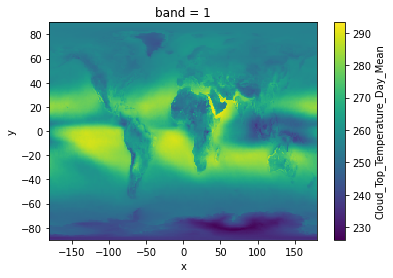

In [16]:
ds_satellite['Cloud_Top_Temperature_Day_Mean'].mean('time').plot()

In [17]:
ds_satellite['month'] = ds_satellite['time.month']
#ds_satellite_sum = ds_satellite.where(ds_satellite['month'].isin([7,8]), drop=True)

## Mask values by r_eff, tau, cloud top temperature and cloud water path: 

In [18]:
ds_satellite_mask = ds_satellite.where(ds_satellite['Cloud_Effective_Radius_Liquid_Mean']>=r_eff_lim)
ds_satellite_mask = ds_satellite_mask.where(ds_satellite_mask['Cloud_Optical_Thickness_Liquid_Mean']>tau_lims[0])
ds_satellite_mask = ds_satellite_mask.where(ds_satellite_mask['Cloud_Optical_Thickness_Liquid_Mean']<tau_lims[1])
ds_satellite_mask = ds_satellite_mask.where(ds_satellite_mask['Cloud_Top_Temperature_Day_Mean']>(cloud_top_temp_above+273.15))
ds_satellite_mask = ds_satellite_mask.where(ds_satellite_mask['Cloud_Water_Path_Liquid_Mean']>=cld_water_path_above)

(array([  110524.,  2138490.,  8572168., 15626957., 24674513., 27398772.,
        23855323., 28044220.,  6942432.,    33324.]),
 array([-88.78999  , -74.93099  , -61.07199  , -47.21299  , -33.35399  ,
        -19.494987 ,  -5.6359863,   8.223015 ,  22.082016 ,  35.941017 ,
         49.80002  ], dtype=float32),
 <BarContainer object of 10 artists>)

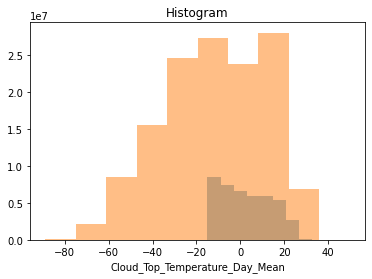

In [19]:
(ds_satellite_mask['Cloud_Top_Temperature_Day_Mean']-273.15).plot.hist(alpha=.5)

(ds_satellite['Cloud_Top_Temperature_Day_Mean']-273.15).plot.hist(alpha=.5)

## Mask values by time

In [20]:
ds_satellite_mask['month'] = ds_satellite_mask['time.month']
ds_satellite_mask['is_JA'] = ds_satellite_mask['month'].isin([7,8])
ds_satellite_mask['is_JJA'] = ds_satellite_mask['month'].isin([6,7,8])
#df_sum = ds_satellite_mask_sum[['Cloud_Effective_Radius_Liquid_Mean']].squeeze().sel(x = slice(*lon_lims), y = slice(*lat_lims[::-1])).to_dataframe()#'band')
#df_sum = df_sum.dropna().reset_index()
#df_sum_cnt = df_sum.groupby([df_sum['y'],df_sum['x']]).count()

## Get correct lat lon:

In [21]:
ds_sat_hyy = ds_satellite_mask.squeeze().sel(x = slice(*lon_lims), y = slice(*lat_lims[::-1]))#.to_dataframe()#'band')

## Get OA data: 

In [22]:
import datetime

In [23]:
from bs_fdbck.constants import path_measurement_data
import pandas as pd

In [24]:
#fn_ATTO_data = path_measurement_data / 'ACSM_DEFAULT.mat'
postproc_data = path_measurement_data /'ATTO'/'processed'

path_comb_data_full_time =postproc_data /'ATTO_data_comb_hourly.nc'

In [25]:
ds_observations = xr.open_dataset(path_comb_data_full_time).sel(time_traj=0)

In [26]:
ds_observations = ds_observations[['N50-500','N100-500','N200-500','OA']]

In [27]:
ds_observations['day_of_year'] = ds_observations['time.dayofyear']
ds_observations['month'] = ds_observations['time.month']

In [28]:
import matplotlib.pyplot as plt

## Daytime OA: 

In [29]:
ds_observations['hour'] = ds_observations['time.hour']

hour = ds_observations['hour']

ds_observations_maskh = ds_observations.where((hour >daytime_from) & (hour<daytime_to))

In [30]:
ds_observations_med_mh = ds_observations_maskh.resample(time='1D').median()
ds_observations_med_mean = ds_observations_maskh.resample(time='1D').mean()

In [31]:
ds_observations_med_mh = ds_observations_med_mh.drop('time_traj')

In [32]:
ds_sat_hyy['OA'] = ds_observations_med_mh['OA']
for v in ds_observations_med_mh.data_vars:
    ds_sat_hyy[v] = ds_observations_med_mh[v]

In [33]:
#df_sat_nonan = ds_sat_hyy.to_dataframe().dropna()

(array([38248., 26893., 16091.,  9725.,  5670.,  3106.,  1682.,   855.,
          415.,   220.]),
 array([ 5.0099998,  9.502    , 13.9939995, 18.486    , 22.978    ,
        27.47     , 31.962    , 36.454    , 40.946    , 45.438    ,
        49.93     ], dtype=float32),
 <BarContainer object of 10 artists>)

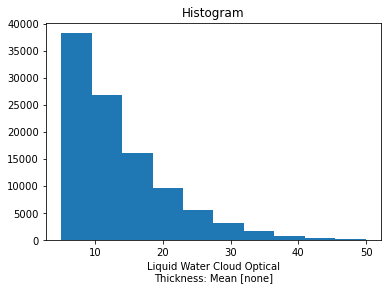

In [34]:
ds_sat_hyy['Cloud_Optical_Thickness_Liquid_Mean'].plot.hist()

In [35]:
#da = df_sat_nonan[['Cloud_Top_Temperature_Day_Maximum']].reset_index().groupby(['y','x']).count().to_xarray()['Cloud_Top_Temperature_Day_Maximum']#.plot()
#da.where(da>110).plot()

In [36]:
#ds_sat_hyy['number_of_values_in_pixel'] = da#

In [37]:
ds_sat_hyy = ds_sat_hyy.rename({'y':'LAT','x':'LON'}).squeeze()#.to_dataframe().dropna()

## Rename vars

In [38]:
ds_sat_hyy_rn = ds_sat_hyy.rename({'Cloud_Effective_Radius_Liquid_Mean':'CER (micrometer)',
                           'Cloud_Optical_Thickness_Liquid_Mean':'COT',
                           'Cloud_Water_Path_Liquid_Mean':'CWP (g m^-2)',
                          'OA':'OA (microgram m^-3)',
                          })

## Save dataset: 

In [39]:
outfilename

PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/MODIS_postproc_lev2/MODIS_date_ATTO.nc')

In [40]:
ds_sat_hyy_rn.to_netcdf(outfilename)

In [41]:
outfilename

PosixPath('/proj/bolinc/users/x_sarbl/analysis/BS-FDBCK/Data/satellite/MODIS_postproc_lev2/MODIS_date_ATTO.nc')

# Extra analysis

In [42]:
df_sat = ds_sat_hyy.to_dataframe().dropna()

KeyboardInterrupt: 

In [ ]:
df_sat_rn = df_sat.rename({'Cloud_Effective_Radius_Liquid_Mean':'CER (micrometer)',
                           'Cloud_Optical_Thickness_Liquid_Mean':'COT',
                           'Cloud_Water_Path_Liquid_Mean':'CWP (g m^-2)',
                          'OA':'OA (microgram m^-3)',
                          }, axis=1)

In [ ]:
ds_sat_rn = df_sat_rn.to_xarray()

In [ ]:
ds_sat_rn

## Div diagnostics

In [ ]:
df_sat['OA_cat'] = np.nan

In [ ]:
high_OA_dic = {1:'high OA', 0:'low OA'}